# Anatomy Classification Model

In [18]:
import os
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,MaxPooling2D,Flatten,Dropout
from keras import regularizers
from keras.optimizers import Adam, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.models import  Sequential
from sklearn import metrics

%matplotlib inline

### For GPU use

In [2]:
# K.tensorflow_backend._get_available_gpus()

In [3]:
# assert len(K.tensorflow_backend._get_available_gpus()) > 0

## Load and organize the data

In [5]:
df = pd.read_csv('train_image_path_fixed.csv')
df.head()

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [6]:
# Adding columns for the anatomy, patient, and the study number
class_names = {1:'positive',0:'negative'}

df['anatomy'] = df['path'].apply(lambda x: str(x.split('/')[2])[3:])
df['patient'] = df['path'].apply(lambda x: str(x.split('/')[3]))
df['study_num'] = df['path'].apply(lambda x: str(x.split('/')[4])[:6])
df['class_label'] = df['path'].apply(lambda x: str(x.split('/')[4])[7:])
df['class'] = df['class_label'].apply(lambda x: 0 if x =='negative' else 1 )

df.head()

,path,anatomy,patient,study_num,class_label,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,positive,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,positive,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,positive,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,positive,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,positive,1


In [6]:
df.to_csv(r'train_anatomy.csv', index=False)

In [7]:
anatomy = pd.read_csv('train_anatomy.csv')
anatomy.head()

,path,anatomy,patient,study_num,class_label,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,positive,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,positive,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,positive,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,positive,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,positive,1


In [8]:
test_df = pd.read_csv('valid_imgs_df.csv')
test_df.head()

,path,anatomy,patient,study_num,class_label,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,positive,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,positive,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,positive,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,positive,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,WRIST,patient11186,study1,positive,1


In [9]:
# Finding the class weights to see the imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(anatomy['anatomy']), anatomy['anatomy'])

In [10]:
class_weights

array([1.06637309, 1.02982486, 2.88125245, 0.94863534, 4.13387242,
       0.62755528, 0.53920075])

## Generating the training and validation data + Preprocessing the images

In [10]:
datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
#     featurewise_center = True,
#     featurewise_std_normalization = True,
    rescale = 1./255,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     rotation_range = 30,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2)


In [11]:
train_generator = datagen.flow_from_dataframe(
    dataframe = anatomy,
    directory = None,
    x_col = "path",
    y_col = "anatomy",
    subset = "training",
#     featurewise_center = True,
#     featurewise_std_normalization = True,
    seed=21,
    batch_size = 32,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

valid_generator = datagen.flow_from_dataframe(
    dataframe = anatomy,
    directory = None,
    x_col = "path",
    y_col = "anatomy",
    subset = "validation",
#     featurewise_center = True,
#     featurewise_std_normalization = True,
    seed=21,
    batch_size = 32,
    shuffle = True,
    class_mode = "categorical",
    target_size = (224, 224))

Found 29447 validated image filenames belonging to 7 classes.
Found 7361 validated image filenames belonging to 7 classes.


In [12]:
# Gathering the test data straight from the directory
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_directory(
'MURA-v1.1/valid',
batch_size=10,
shuffle=False,
target_size=(224, 224))

Found 3197 images belonging to 7 classes.


## Customizing the Mobilenet model

In [216]:
# Instantiating the model
model = MobileNet(weights='imagenet')

In [217]:
# Customizing the model
x = model.layers[-6].output
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

In [218]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [220]:
# Unfreezing layers from -6 to the end so they can be trained 
for layer in model.layers[-6:]:
    layer.trainable = True

## Customizing the Inception model

In [222]:
# Setting the input size for the model
# input_tensor = Input(shape=(224, 224, 3))

In [223]:
# Instantiating the model
# base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False, )

# Adding layers 
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)

# predictions = Dense(7, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

In [224]:
# Freezing layers so they are untrainable
# for layer in model.layers[:249]:
#    layer.trainable = False

In [225]:
# Unfreezing layers so they are trainable 
# for layer in model.layers[249:]:
#    layer.trainable = True

## Training the model and scoring it

In [226]:
# Compiling the model with hyperparameters
model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fitting the model
model.fit_generator(train_generator, steps_per_epoch= 163, 
                    validation_data=valid_generator, validation_steps= 148, epochs=10, verbose=1)

Epoch 1/10
163/163 [==============================] - 45s 276ms/step - loss: 0.4004 - acc: 0.8700 - val_loss: 0.1978 - val_acc: 0.9428
Epoch 2/10
163/163 [==============================] - 37s 226ms/step - loss: 0.1564 - acc: 0.9532 - val_loss: 0.0936 - val_acc: 0.9749
Epoch 3/10
163/163 [==============================] - 37s 227ms/step - loss: 0.1385 - acc: 0.9613 - val_loss: 0.0736 - val_acc: 0.9778
Epoch 4/10
163/163 [==============================] - 37s 228ms/step - loss: 0.1302 - acc: 0.9649 - val_loss: 0.0423 - val_acc: 0.9889
Epoch 5/10
163/163 [==============================] - 37s 228ms/step - loss: 0.1165 - acc: 0.9699 - val_loss: 0.1035 - val_acc: 0.9694
Epoch 6/10
163/163 [==============================] - 37s 227ms/step - loss: 0.1016 - acc: 0.9717 - val_loss: 0.1322 - val_acc: 0.9590
Epoch 7/10
163/163 [==============================] - 37s 226ms/step - loss: 0.0552 - acc: 0.9847 - val_loss: 0.1343 - val_acc: 0.9588
Epoch 8/10
163/163 [==============================] - 3

In [13]:
# Get the correct guesses
test_labels = test_generator.classes

In [14]:
# Loading the saved model
with open('flask/models/anatomy_mobilef2.json', 'r') as f:
    anatomy_model = model_from_json(f.read())
    anatomy_model.load_weights('flask/models/anatomy_mobilef2.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# Evaluating the model
Y_pred = anatomy_model.predict_generator(test_generator, steps=round(test_generator.n/10), verbose=1)

320/320 [==============================] - 246s 768ms/step


In [16]:
# Creating a confusiion matrix with the results 
matrix = confusion_matrix(test_labels, Y_pred.argmax(axis=1))
matrix

array([[425,   3,   3,   0,   1,  26,   7],
       [  1, 438,   1,   8,   0,  11,   2],
       [ 12,   7, 256,   1,   3,   9,  13],
       [  0,  49,   2, 401,   0,   2,   6],
       [  8,   3,  18,   0, 240,  18,   1],
       [  4,   2,   0,   0,   3, 553,   1],
       [  1,   9,  12,   6,   1,  22, 608]])

In [24]:
# Getting the metrics from the model results 
print(metrics.classification_report(test_labels, Y_pred.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.942     0.914     0.928       465
           1      0.857     0.950     0.901       461
           2      0.877     0.850     0.863       301
           3      0.964     0.872     0.916       460
           4      0.968     0.833     0.896       288
           5      0.863     0.982     0.919       563
           6      0.953     0.923     0.938       659

    accuracy                          0.914      3197
   macro avg      0.918     0.904     0.909      3197
weighted avg      0.917     0.914     0.914      3197



In [20]:
# Getting the Class indices to generate a heatmap
test_classes = test_generator.class_indices

In [21]:
tc = np.array(list(test_classes.keys()))

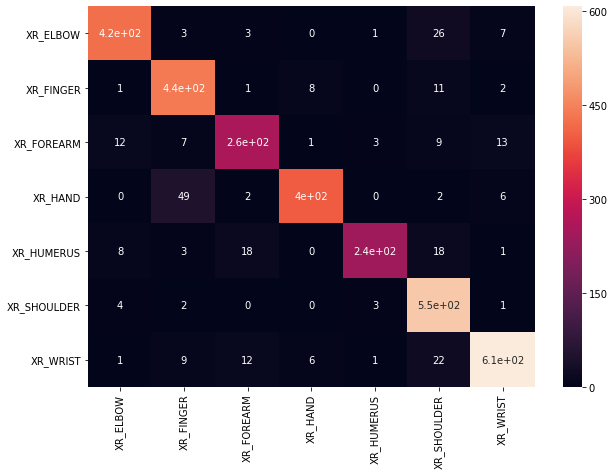

In [25]:
# Creating a heatmap of the confusion matrix results 
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [i for i in tc],
                  columns = [i for i in tc])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [202]:
# Saving the model 
with open('models/anatomy_mobile2.json', 'w') as f:
    f.write(model.to_json())

# Saving the model weights
model.save_weights("models/anatomy_mobile2.h5")